参考：[xiaobaoonline
/
pytorch-in-action](https://github.com/xiaobaoonline/pytorch-in-action)

In [1]:
import torch
from torch.autograd import Variable
import numpy as np

from itertools import count
import torch.nn.functional as F 

import matplotlib. pyplot as plt
import torch.nn as nn


In [21]:
random_state = 5000
torch.manual_seed(random_state)
POLY_DEGREE = 4
W_target = torch.randn(POLY_DEGREE, 1) * 5
b_target = torch.randn(1) * 5

In [22]:
def make_features(x):
    """创建一个特征矩阵结构为[x, x^2, x^3, x^4]."""
    # tensor([1,2,3])变成tensor([[1],[2],[3],[4]])
    x = x.unsqueeze(1)
    # 矩阵根据每一唯独计算 x^i次方，然后cat(x,1)拼成相关特征
    return torch.cat([x ** i for i in range(1, POLY_DEGREE + 1)], 1)

def f(x):
    """近似函数."""
    # 矩阵标准乘法
    return x.mm(W_target) + b_target[0]

def poly_desc(W, b):
    """生成多向式描述内容."""
    result = 'y = '
    for i, w in enumerate(W):
        result += '{:+.2f} x^{} '.format(w, len(W) - i)
    result += '{:+.2f}'.format(b[0])
    return result

def get_batch(batch_size=32):
    """创建类似 (x, f(x))的批数据."""
    random = torch.from_numpy(np.sort(torch.randn(batch_size)))
    x = make_features(random)
    y = f(x)
    return Variable(x), Variable(y)

In [23]:
# 声明模型
fc = torch.nn.Linear(W_target.size(0), 1)

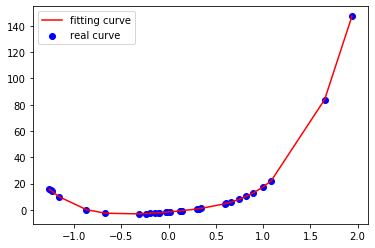

Loss: 0.000518 after 760 batches
==> Learned function:	y = +6.07 x^4 +3.91 x^3 +0.90 x^2 +8.19 x^1 -1.64
==> Actual function:	y = +6.13 x^4 +3.89 x^3 +0.86 x^2 +8.20 x^1 -1.62


In [24]:
for batch_idx in count(1):
    # 获取数据
    batch_x, batch_y = get_batch()

    # 重置求导
    fc.zero_grad()

    # 前向传播
    output = F.smooth_l1_loss(fc(batch_x), batch_y)
    
    if output.data.size() == torch.Size([]):
        loss = output.data.item()
    else:
        loss = output.data[0]
    

    # 后向传播
    output.backward()

    # 应用导数
    for param in fc.parameters():
        # 学习率与曲线
        param.data.add_(-0.1 * param.grad.data)

    # 停止条件
    if loss < 1e-3:
        plt.cla()
        plt.scatter(batch_x.data.numpy()[:, 0], batch_y.data.numpy()[:, 0], label='real curve', color='b')
        plt.plot(batch_x.data.numpy()[:, 0], fc(batch_x).data.numpy()[:, 0], label='fitting curve', color='r')
        plt.legend()
        plt.show()
        break

print('Loss: {:.6f} after {} batches'.format(loss, batch_idx))
print('==> Learned function:\t' + poly_desc(fc.weight.data.view(-1), fc.bias.data))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))